# Data Overview

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.patches import Patch
import matplotlib.dates as mdates



from fault_management_uds.data.format import create_indicator
from fault_management_uds.data.load import import_external_metadata, import_metadata
from fault_management_uds.data.HDF5_functions import delete_group, create_group, print_tree, save_dataframe_in_HDF5, load_dataframe_from_HDF5, update_filtered_data_in_HDF5
from fault_management_uds.config import bools_2_meta, error_indicators, sensor_2_alias, indicator_2_meta
from fault_management_uds.plots import set_meaningful_xaxis_timestamps, get_segment_start_end_color, convert_to_matplotlib_dates


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import natural_sensor_order, natural_structure_order, structure_2_sensor, rain_gauges


2024-11-10 20:45:38.587 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


#### Prepare

In [2]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'

f = print_tree(data_file_path)

root
├── combined_data
│   ├── clean
│   │   ├── columns
│   │   ├── data
│   │   └── timestamps
│   └── raw
│       ├── columns
│       ├── data
│       └── timestamps
└── single_series
    ├── rain_gauge_data
    │   ├── 5425
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   └── 5427
    │       ├── columns
    │       ├── data
    │       └── timestamps
    └── sewer_data
        ├── G71F04R_Level1
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   └── raw
        │       ├── columns
        │       ├── data
        │       └── timestamps
        ├── G71F04R_Level2
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │ 

In [3]:
# for sensor and raw value file, check total average value, and average when positive
metadata = import_metadata(REFERENCE_DIR / 'external_metadata.csv')
sensor_metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')
raw_sensor_path = RAW_DATA_DIR / 'Bellinge' / 'sensor-data'
provided_processed_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'sensor-data' / '2_cleaned_data'


scripts_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'scripts'
external_metadata, manual_remove = import_external_metadata(scripts_path)


# Data Coverage

### Load necessary data

In [4]:
starttime = metadata['StartTime'].min()
endtime = metadata['EndTime'].max()

print(f"Start time: {starttime}")
print(f"End time: {endtime}")

Start time: 2010-01-01 00:00:00
End time: 2021-08-19 00:00:00


In [5]:
# load clean and bools for the whole dataset and create the indicator
clean, _, _, _ = load_dataframe_from_HDF5(data_file_path, 'combined_data/clean', starttime, endtime, complete_range=True)

In [6]:
# create an empty indicator
# create a template df for the combined data
time_range = pd.date_range(start=starttime, end=endtime, freq='1min')
# default to zeros
variables = rain_gauges + natural_sensor_order
empty_data = np.zeros((len(time_range), len(variables)))
indicator = pd.DataFrame(empty_data, columns=variables)
indicator['time'] = time_range
indicator.set_index('time', inplace=True)


In [7]:

for rain_gague in tqdm(rain_gauges, total=len(rain_gauges)):
    # create the indicator
    obvious_min = 0
    bools = pd.DataFrame()
    _indicator = create_indicator(clean, rain_gague, bools, [], starttime, endtime, obvious_min)
    # save the indicator in the full indicator
    indicator.loc[:, rain_gague] = _indicator.loc[:, 'value']


# for each sensor, load the bools and create the indicator
for sensor_name in tqdm(natural_sensor_order, total=len(natural_sensor_order)):
    # load the bools
    bools, _, _, _ = load_dataframe_from_HDF5(data_file_path, f'single_series/sewer_data/{sensor_name}/bools', starttime, endtime, complete_range=True)
    # create the indicator
    obvious_min = sensor_metadata[sensor_metadata['IdMeasurement'] == sensor_name]['obvious_min'].values[0]
    _indicator = create_indicator(clean, sensor_name, bools, error_indicators, starttime, endtime, obvious_min)
    # save the indicator in the full indicator
    indicator.loc[:, sensor_name] = _indicator.loc[:, 'value']

  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:02<00:48,  2.69s/it]

 11%|█         | 2/19 [00:05<00:48,  2.85s/it]

 16%|█▌        | 3/19 [00:08<00:46,  2.90s/it]

 21%|██        | 4/19 [00:11<00:43,  2.88s/it]

 26%|██▋       | 5/19 [00:16<00:50,  3.58s/it]

 32%|███▏      | 6/19 [00:20<00:50,  3.92s/it]

 37%|███▋      | 7/19 [00:25<00:50,  4.21s/it]

 42%|████▏     | 8/19 [00:28<00:40,  3.72s/it]

 47%|████▋     | 9/19 [00:31<00:34,  3.42s/it]

 53%|█████▎    | 10/19 [00:35<00:34,  3.82s/it]

 58%|█████▊    | 11/19 [00:40<00:33,  4.22s/it]

 63%|██████▎   | 12/19 [00:45<00:30,  4.34s/it]

 68%|██████▊   | 13/19 [00:50<00:26,  4.47s/it]

 74%|███████▎  | 14/19 [00:55<00:23,  4.65s/it]

 79%|███████▉  | 15/19 [01:00<00:18,  4.66s/it]

 84%|████████▍ | 16/19 [01:05<00:14,  4.79s/it]

 89%|████████▉ | 17/19 [01:10<00:09,  4.89s/it]

 95%|█████████▍| 18/19 [01:13<00:04,  4.47s/it]

100%|██████████| 19/19 [01:17<00:00,  4.10s/it]


In [8]:
del clean, bools, _indicator

In [9]:
indicator_2_color = {k: v['color'] for k, v in indicator_2_meta.items()}
name_2_color = {v['alias']: v['color'] for k, v in indicator_2_meta.items()}

In [10]:
def visualize_combined_timeline(ax, I, start, end, indicator_2_color, name_2_color):
    # Reshape I
    _I = I.copy().values.T
    start, end = I.index[0], I.index[-1]
    bar_width = 0.6

    # Iterate over each row in the 2D array I to plot segments
    for i, row in enumerate(_I):
        segment_starts, segment_ends, segment_color = get_segment_start_end_color(row, indicator_2_color)
        segment_starts, segment_ends = convert_to_matplotlib_dates(segment_starts, segment_ends, starttime)
        # Calculate durations
        segments = np.column_stack((segment_starts, segment_ends - segment_starts))
        # plot the segments
        ax.broken_barh(segments, (i - bar_width/2, bar_width), facecolors = segment_color) 

    # Set the legend
    legend_elements = [Patch(facecolor=color, label=name) for name, color in name_2_color.items()]
    # Add legend: at the bottom of the plot, centered horizontally and stretched to the width of the plot
    ax.legend(handles=legend_elements, loc='lower center', ncol=len(legend_elements), frameon=False, bbox_to_anchor=(0.5, -0.17), fontsize=12)

    # # Set the y-ticks and labels
    ax.set_yticks(np.arange(len(I.columns)))
    ax.set_yticklabels(I.columns)
    ax.invert_yaxis()

    # Set the x-axis
    ax.set_xlim(I.index[0], I.index[-1])
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format in Day-Month-Year Hour:Minute
    ax.tick_params(axis='x', which='major', labelsize=10, rotation=0, pad=5.5)#, labelcolor='navy')

    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False)
    return ax

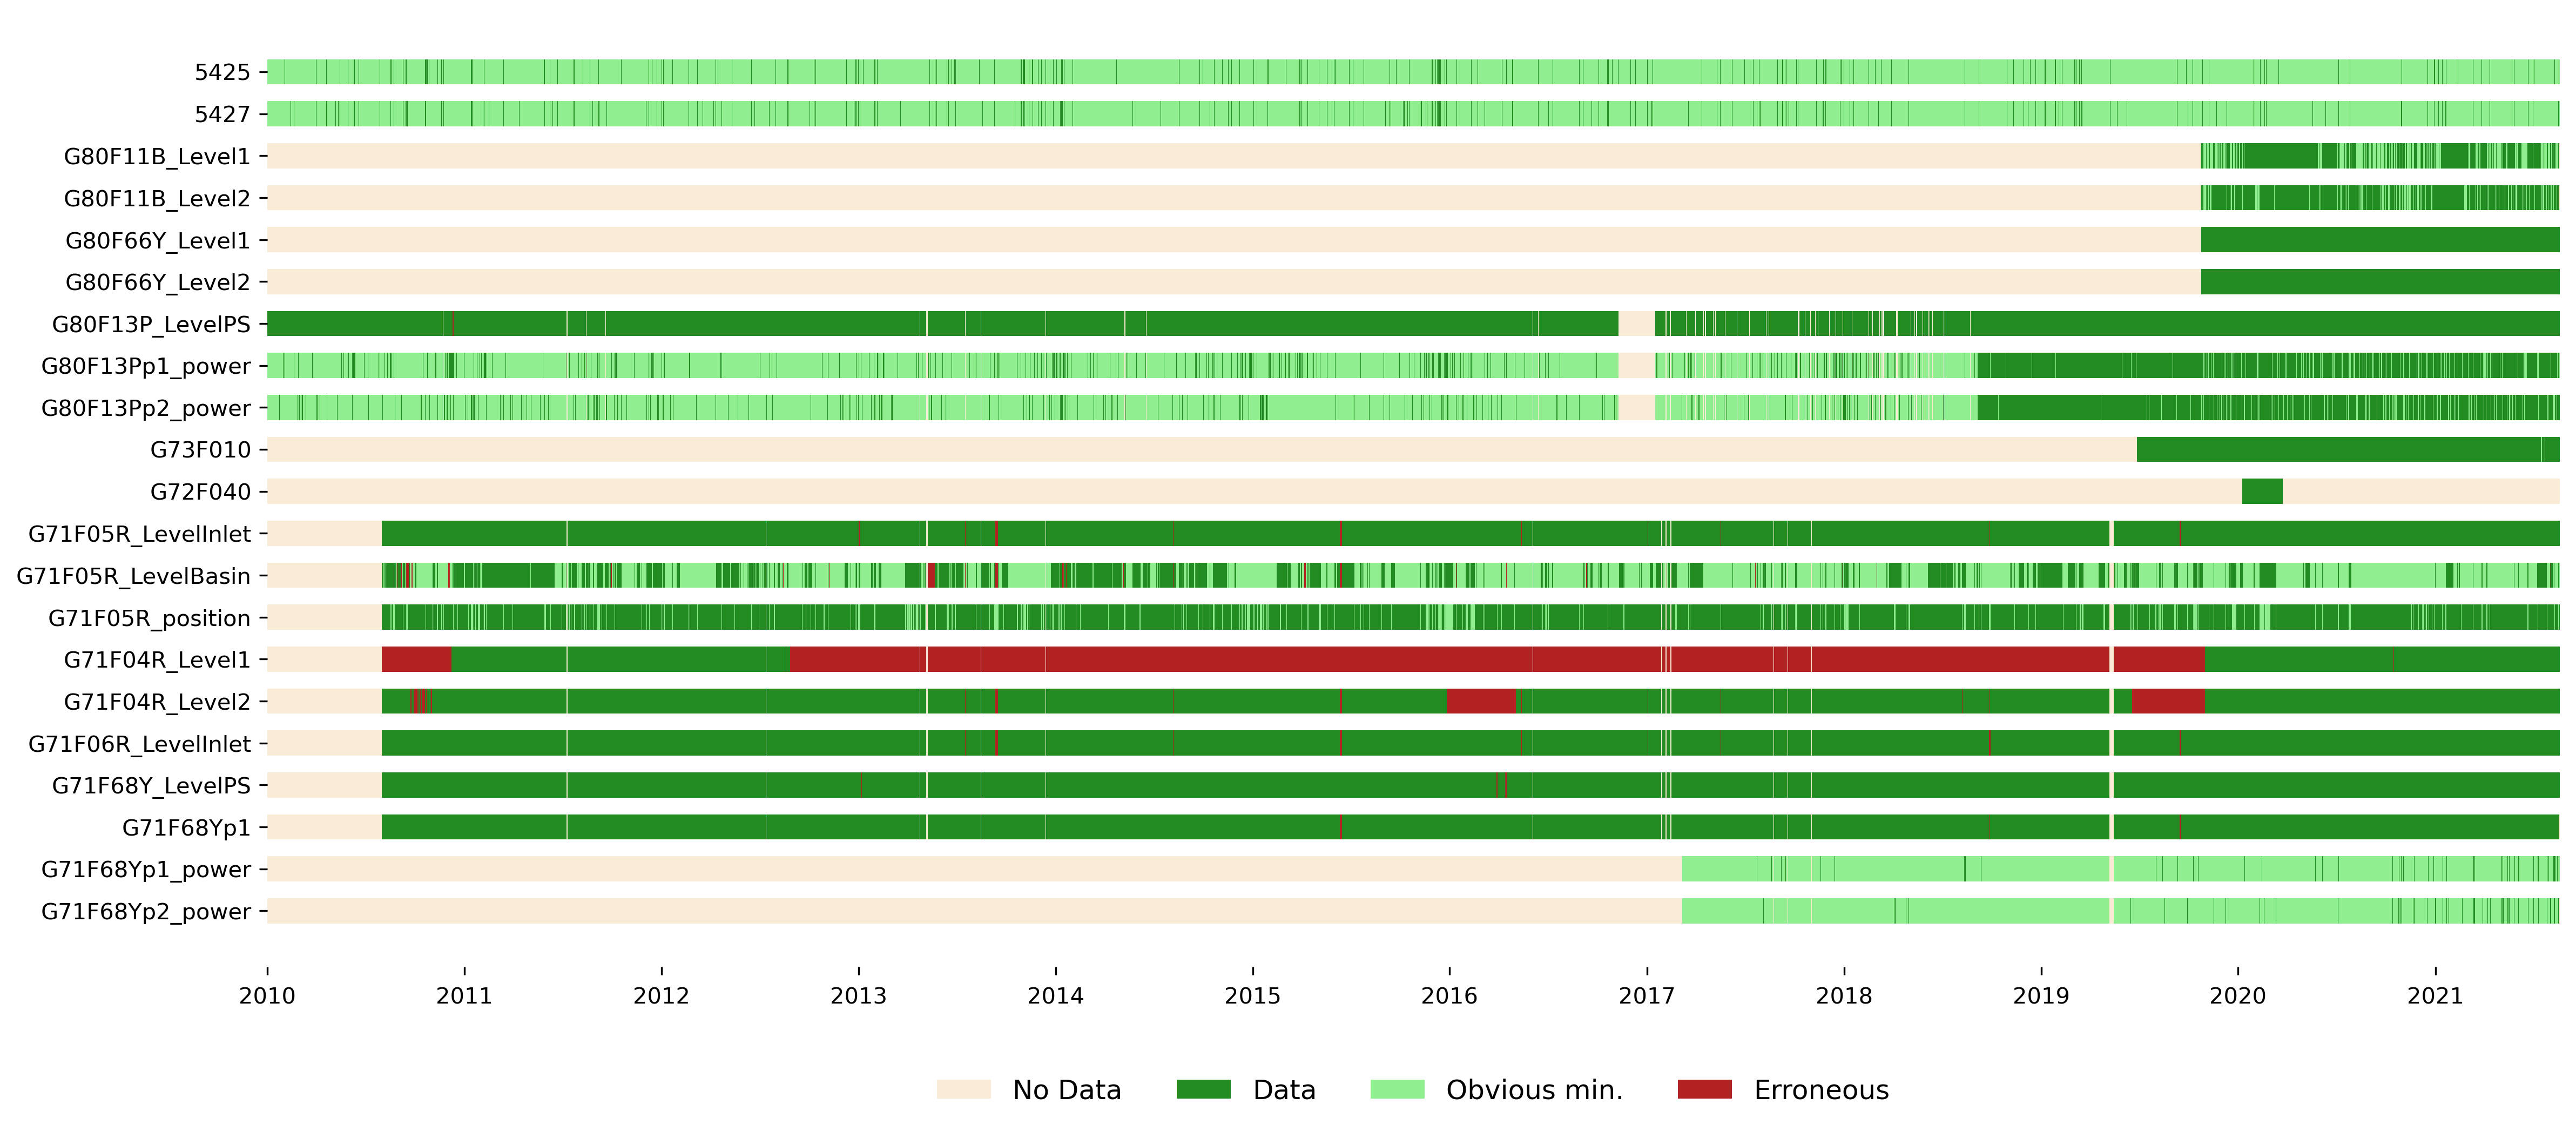

In [11]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(16, 7), dpi=300)

ax = visualize_combined_timeline(ax, indicator, starttime, endtime, indicator_2_color, name_2_color)
# Show the plot
plt.tight_layout()
# save the plot
plt.savefig(FIGURES_DIR / 'dataset' / 'coverage.png', dpi=300)
plt.show()
plt.close()

# Overview table

##### Interested in:


One table for:
- total data points
- total normal
- total zero
- total no data
- total error

A visualization and comparison of each error count


In [12]:

def latex_with_group_hlines(latex_code, group_values):
    """
    Add horizontal lines after each group of values in a LaTeX table.
    The function takes a LaTeX table as a string and a list of group values.
    It then adds a horizontal line after each group of values in the table.
    """


    # Split the LaTeX code into lines
    latex_lines = latex_code.splitlines()

    # Create a new list of LaTeX lines with added \hline after each group
    new_latex_lines = []
    for i, line in enumerate(latex_lines):
        # check if any group value is in the line
        if any(group_value in line for group_value in group_values):
            if 'rule' not in latex_lines[i-1]:
                new_latex_lines.append(r"\hline")
        new_latex_lines.append(line)
    # Rejoin the lines into a single LaTeX string
    latex_code_with_hline = "\n".join(new_latex_lines)

    return latex_code_with_hline

    
def latex_multicolumn_headers(df, latex_code):

    # Replace the headers with \multicolumn for centering
    headers = df.columns
    for header in headers:
        latex_code = latex_code.replace(header, r"\multicolumn{1}{c}{" + header + "}")
    
    return latex_code

#### Coverage table

In [13]:
overview_table = pd.DataFrame(columns=['Structure', 'Sensor', 'Valid Data', 'No Data', 'Erroneous'])

# List to store rows of the table
table_rows = []


for structure_name in natural_structure_order:
    sensors = structure_2_sensor[structure_name]
    for sensor_name in sensors:
        sensor_meta = metadata[metadata['IdMeasurement'] == sensor_name]
        sensor_meta = sensor_meta.sort_values(by='StartTime')

        available = 0
        valid = 0
        erroneous = 0
        no_data = 0


        # combine metadata files
        for i, meta in sensor_meta.iterrows():
            # load indicator data from this period
            start = meta['StartTime']
            end = meta['EndTime']
            _indicator = indicator.loc[start:end, sensor_name].copy()
            valid += _indicator[_indicator == 1].shape[0]
            valid += _indicator[_indicator == -1].shape[0]
            erroneous += _indicator[_indicator == 2].shape[0]
            no_data += _indicator[_indicator == 0].shape[0]


        # Create a new row for the table
        row_data = {
            'Structure': structure_name,
            'Sensor': sensor_2_alias[sensor_name],
            'Valid Data': valid,
            'No Data': no_data,
            'Erroneous': erroneous,
        }

        # Append the row to the list
        table_rows.append(row_data)


# Convert the list of rows into a DataFrame
overview_table = pd.DataFrame(table_rows)

In [14]:
table = overview_table.copy()

# Function to format numbers with punctuation
def format_number(x):
    if isinstance(x, (int, float)):
        return f"{x:,.0f}".replace(',', ' ')
    return x

# Apply the formatting function to the DataFrame
table = table.applymap(format_number)

# Replace duplicates in 'Structure' column with empty strings
unique_structures = table['Structure'].unique()
table['Structure'] = table['Structure'].where(table['Structure'] != table['Structure'].shift(), '')


# Convert to LaTeX table
table = table.replace('0', '-') # Replace 0 with '-'
latex_code = table.to_latex(index=False, column_format="llrrr")#, escape=False)

#latex_code = latex_multicolumn_headers(table, latex_code)

# Add \hline after each group in the 'Structure' column
latex_code_with_hline = latex_with_group_hlines(latex_code, unique_structures)

# Print or save the LaTeX code
print(latex_code_with_hline)

\begin{tabular}{llrrr}
\toprule
Structure & Sensor & Valid Data & No Data & Erroneous \\
\midrule
G80F11B & Basin Level (1) & 956 813 & 2 066 & 162 \\
 & Basin Level (2) & 956 781 & 2 099 & 161 \\
\hline
G80F66Y & Inlet Level (1) & 956 740 & 2 121 & 180 \\
 & Inlet Level (2) & 956 594 & 2 267 & 180 \\
\hline
G80F13P & Pump Sump Level & 5 933 213 & 180 311 & 2 158 \\
 & Pump 1 Power & 5 934 443 & 180 729 & 510 \\
 & Pump 2 Power & 5 934 303 & 180 881 & 498 \\
\hline
G73F010 & Pipe Level & 1 128 949 & - & 12 \\
\hline
G72F040 & Pipe Level & 107 479 & 316 & 206 \\
\hline
G71F05R & Inlet Level & 5 748 360 & 31 639 & 30 403 \\
 & Basin Level & 5 697 186 & 31 644 & 81 572 \\
 & Throttle Position & 5 777 898 & 31 652 & 852 \\
\hline
G71F04R & Pipe Level (1) & 1 841 856 & 31 674 & 3 938 314 \\
 & Pipe Level (2) & 5 342 839 & 31 682 & 437 323 \\
\hline
G71F06R & Inlet Level & 5 749 829 & 31 640 & 28 933 \\
\hline
G71F68Y & Pump Sump Level & 5 769 414 & 32 121 & 8 867 \\
 & Pump 1 Flow & 5 764 5

#### Error overview table

In [15]:
# List to store rows of the table
table_rows = []

for structure_name in tqdm(natural_structure_order, total=len(natural_structure_order)):
    sensors = structure_2_sensor[structure_name]
    for sensor_name in sensors:
        sensor_meta = metadata[metadata['IdMeasurement'] == sensor_name]
        sensor_meta = sensor_meta.sort_values(by='StartTime')

        row_data = {
            'Structure': structure_name,
            'Sensor': sensor_2_alias[sensor_name],

        }
        for error_indicator in error_indicators:
            row_data[error_indicator] = 0

        # combine metadata files
        for i, meta in sensor_meta.iterrows():
            # load indicator data from this period
            start = meta['StartTime']
            end = meta['EndTime']
            # load the bools
            bools, _, _, _ = load_dataframe_from_HDF5(data_file_path, f'single_series/sewer_data/{sensor_name}/bools', start, end, complete_range=True)

            for error_indicator in error_indicators:
                row_data[error_indicator] += bools[error_indicator].sum()


        # Append the row to the list
        table_rows.append(row_data)


# Convert the list of rows into a DataFrame
overview_table = pd.DataFrame(table_rows)

del bools

  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:00<00:07,  1.09it/s]

 22%|██▏       | 2/9 [00:01<00:06,  1.09it/s]

 44%|████▍     | 4/9 [00:12<00:16,  3.39s/it]

 67%|██████▋   | 6/9 [00:21<00:11,  3.98s/it]

 78%|███████▊  | 7/9 [00:32<00:11,  5.78s/it]

 89%|████████▉ | 8/9 [00:35<00:04,  4.90s/it]

100%|██████████| 9/9 [00:43<00:00,  4.78s/it]

In [19]:
len(error_indicators)

5

In [20]:
error_2_alias = {k: v['alias'] for k, v in bools_2_meta.items()}
# rename the columns
overview_table.rename(columns=error_2_alias, inplace=True)

In [21]:
table = overview_table.copy()

# Function to format numbers with punctuation
def format_number(x):
    if isinstance(x, (int, float)):
        return f"{x:,.0f}".replace(',', ' ')
    return x

# Apply the formatting function to the DataFrame
table = table.applymap(format_number)

# Replace duplicates in 'Structure' column with empty strings
unique_structures = table['Structure'].unique()
table['Structure'] = table['Structure'].where(table['Structure'] != table['Structure'].shift(), '')


# Convert to LaTeX table
table = table.replace('0', '-') # Replace 0 with '-'
latex_code = table.to_latex(index=False, column_format="llrrrrr")#, escape=False)

#latex_code = latex_multicolumn_headers(table, latex_code)

# Add \hline after each group in the 'Structure' column
latex_code_with_hline = latex_with_group_hlines(latex_code, unique_structures)

# Print or save the LaTeX code
print(latex_code_with_hline)

\begin{tabular}{llrrrrr}
\toprule
Structure & Sensor & Removed & Stamped & Outbound & Outlier & Frozen \\
\midrule
G80F11B & Basin Level (1) & - & 162 & - & - & - \\
 & Basin Level (2) & - & 161 & - & - & - \\
\hline
G80F66Y & Inlet Level (1) & - & 175 & 180 & - & - \\
 & Inlet Level (2) & - & 174 & 180 & - & - \\
\hline
G80F13P & Pump Sump Level & - & 604 & 922 & - & 1 236 \\
 & Pump 1 Power & - & 495 & 15 & - & - \\
 & Pump 2 Power & - & 493 & 5 & - & - \\
\hline
G73F010 & Pipe Level & - & - & - & 12 & - \\
\hline
G72F040 & Pipe Level & - & - & 206 & - & - \\
\hline
G71F05R & Inlet Level & - & 165 & 5 259 & - & 25 337 \\
 & Basin Level & - & 165 & 44 918 & - & 36 531 \\
 & Throttle Position & - & 165 & 687 & - & - \\
\hline
G71F04R & Pipe Level (1) & 3 223 622 & 199 & 3 934 155 & - & 3 702 \\
 & Pipe Level (2) & 90 & 198 & 232 878 & - & 204 586 \\
\hline
G71F06R & Inlet Level & - & 167 & 5 178 & - & 23 766 \\
\hline
G71F68Y & Pump Sump Level & - & 110 & 8 867 & - & - \\
 & Pump 1 Flo

#### Making a similar table for the provided

In [22]:
from fault_management_uds.data.load import load_data_period, filenames_based_on_period, provided_2_full_range, get_event

# Provided sensor path
provided_processed_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'sensor-data' / '2_cleaned_data'


In [23]:
# List to store rows of the table
table_rows = []


for structure_name in tqdm(natural_structure_order, total=len(natural_structure_order)):
    sensors = structure_2_sensor[structure_name]
    for sensor_name in sensors:
        sensor_meta = metadata[metadata['IdMeasurement'] == sensor_name]
        sensor_meta = sensor_meta.sort_values(by='StartTime')

        row_data = {
            'Structure': structure_name,
            'Sensor': sensor_2_alias[sensor_name],

        }

        for error_indicator in error_indicators:
            row_data[error_indicator] = 0


        # combine metadata files
        for i, meta in sensor_meta.iterrows():
            save_name = meta['ProvidedSaveName']
            if pd.isna(save_name):
                continue # go to the next iteration
            
            # load indicator data from this period
            start = meta['StartTime']
            end = meta['EndTime']

            provided_processed = load_data_period(provided_processed_path, [save_name], start, end, filetype='csv', fillna_with=np.nan)
            if provided_processed is None:
                provided_processed = pd.DataFrame(columns=['raw_value', 'value_no_errors', 'man_remove','ffill', 'stamp','outbound', 'frozen', 'outlier', 'frozen_high', 'depth_s', 'level'], 
                                                                index=pd.DatetimeIndex([]))
                print(f"Provided data for {sensor_name} is missing for the period {start} to {end}")
            else:
                provided_processed = provided_2_full_range(provided_processed, start, end, error_indicators)

            for error_indicator in error_indicators:
                row_data[error_indicator] += provided_processed[error_indicator].sum()

        # Append the row to the list
        table_rows.append(row_data)


# Convert the list of rows into a DataFrame
overview_table = pd.DataFrame(table_rows)

100%|██████████| 9/9 [01:07<00:00,  7.48s/it]


In [24]:
error_2_alias = {k: v['alias'] for k, v in bools_2_meta.items()}
# rename the columns
overview_table.rename(columns=error_2_alias, inplace=True)

In [25]:
overview_table

,Structure,Sensor,Removed,Stamped,Outbound,Outlier,Frozen
0,G80F11B,Basin Level (1),0,46,0,0,0
1,G80F11B,Basin Level (2),0,46,0,0,0
2,G80F66Y,Inlet Level (1),0,36,38,0,0
3,G80F66Y,Inlet Level (2),0,36,39,0,0
4,G80F13P,Pump Sump Level,0,57,353,0,1224
5,G80F13P,Pump 1 Power,0,0,0,0,0
6,G80F13P,Pump 2 Power,0,0,0,0,0
7,G73F010,Pipe Level,0,0,0,4,0
8,G72F040,Pipe Level,0,0,103,0,0
9,G71F05R,Inlet Level,0,53,4533,0,28531


## Comparison between number of clean values

In [26]:
import seaborn as sns

In [27]:

# List to store rows of the table
adjusted_rows = []
provided_rows = []

starttime = metadata['StartTime'].min()
endtime = metadata['EndTime'].max()

clean, _, _, _ = load_dataframe_from_HDF5(data_file_path, 'combined_data/clean', starttime, endtime, complete_range=True)


for sensor_name in tqdm(natural_sensor_order, total=len(natural_sensor_order)):
    sensor_meta = metadata[metadata['IdMeasurement'] == sensor_name]
    sensor_meta = sensor_meta.sort_values(by='StartTime')

    provided_row = {
        'Pipeline': 'Provided',
        'Sensor': sensor_name,
        'Data Count': 0
    }

    adjusted_row = {
        'Pipeline': 'Adjusted',
        'Sensor': sensor_name,
        'Data Count': 0
    }
    # combine metadata files
    for i, meta in sensor_meta.iterrows():
        # load indicator data from this period
        start = meta['StartTime']
        end = meta['EndTime']

        # adjusted
        adjusted_row['Data Count'] += clean.loc[start:end, sensor_name].notna().sum()

        # provided
        save_name = meta['ProvidedSaveName']
        if pd.isna(save_name):
            continue # go to the next iteration
    
        provided_processed = load_data_period(provided_processed_path, [save_name], start, end, filetype='csv', fillna_with=np.nan)
        if provided_processed is None:
            provided_processed = pd.DataFrame(columns=['raw_value', 'value_no_errors', 'man_remove','ffill', 'stamp','outbound', 'frozen', 'outlier', 'frozen_high', 'depth_s', 'level'], 
                                                            index=pd.DatetimeIndex([]))
            print(f"Provided data for {sensor_name} is missing for the period {start} to {end}")
        else:
            provided_processed = provided_2_full_range(provided_processed, start, end, error_indicators)

        provided_row['Data Count'] += provided_processed['depth_s'].notna().sum()

    # Append the row to the list
    adjusted_rows.append(adjusted_row)
    provided_rows.append(provided_row)



# Convert the list of rows into a DataFrame
adjusted_table = pd.DataFrame(adjusted_rows)
provided_table = pd.DataFrame(provided_rows)
# concatenate the tables
table = pd.concat([provided_table, adjusted_table], ignore_index=True)

del clean

100%|██████████| 19/19 [01:08<00:00,  3.61s/it]


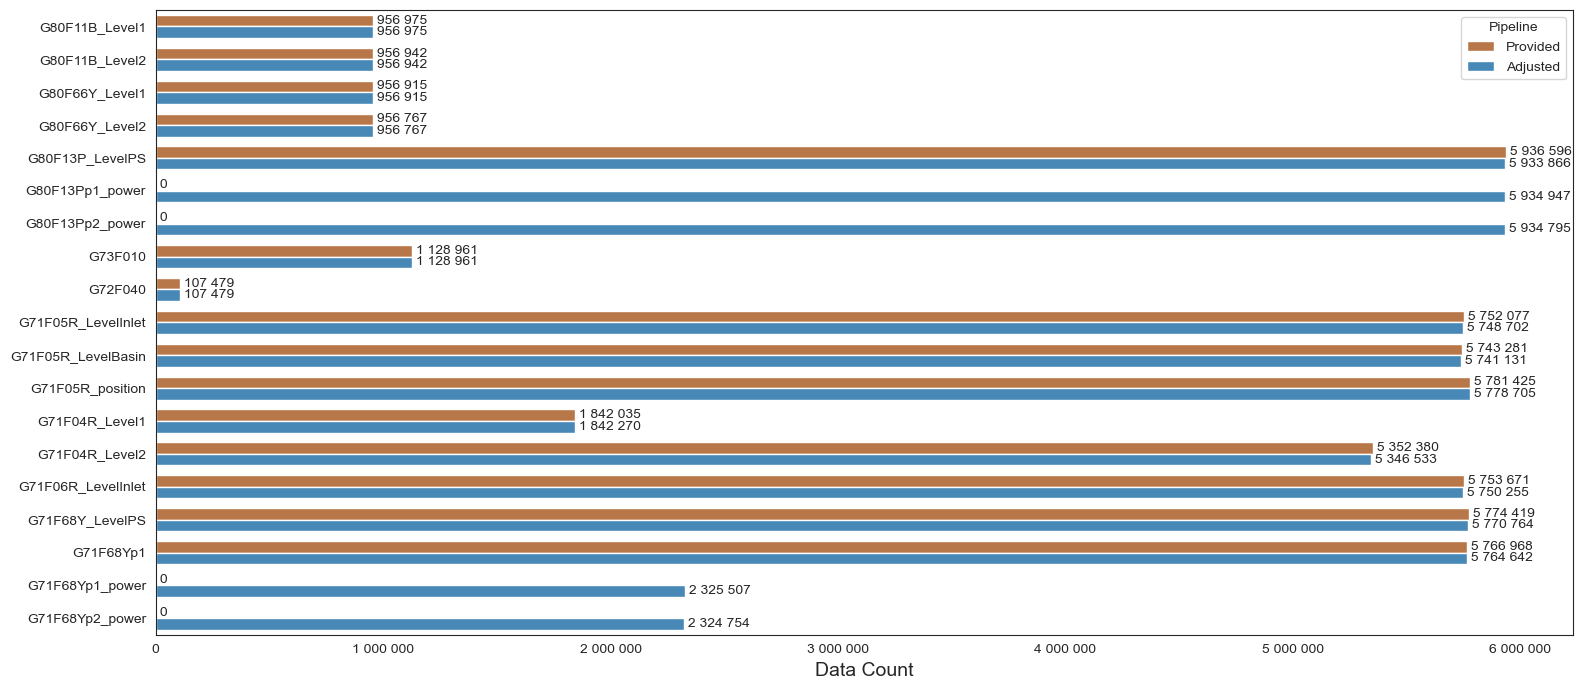

In [67]:
# Assuming 'table' is your DataFrame
plt.figure(figsize=(16, 7))#, dpi=150)  # Set the size of the plot
sns.set_style("white")

custom_colors = ['#B77748', '#4888B7']
# Create a horizontal bar plot
ax = sns.barplot(data=table, y='Sensor', x='Data Count', hue='Pipeline', palette=custom_colors, ci=None, width=0.7, saturation=1)

# Add the actual count at the end of each bar
for container in ax.containers:
    labels = [f' {int(label):,}'.replace(',', ' ') for label in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='edge')


# Add labels and title
plt.xlabel('Data Count', fontsize=14)
plt.ylabel('', fontsize=14)

# format xticks to have thousand separator as a space
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)).replace(',', ' ')))

# Adjust the legend
plt.legend(title='Pipeline', loc='upper right')

plt.tight_layout()
# save the plot
plt.savefig(FIGURES_DIR / 'processing' / 'pipeline_clean_count.png', dpi=200)
plt.show()